In [1]:
import scanpy as sc
import anndata
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from scipy import io
# from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
# import seaborn as sns
# import os

# # scTRS tools
# import scdrs.util as util
# import scdrs.data_loader as dl
# import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DF_HOM = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}

# Load data 
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
adata = read_h5ad(DATA_PATH+'/simulation_data/single_cell_data/tms_facs.ncell_10k.h5ad')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=1000)
adata = adata[:, sorted(set(adata.var_names) & set(DF_HOM['MOUSE_GENE_SYM']))].copy()
print('# Load data: n_cell=%d, n_gene=%d'%adata.shape)

np.random.seed(0)
cell_list = np.random.choice(adata.obs_names, size=30, replace=False)
gene_list = np.random.choice(adata.var_names, size=2500, replace=False)
adata = adata[cell_list, gene_list].copy()
print('# Small data: n_cell=%d, n_gene=%d'%adata.shape)

# Cell-level and gene-level variables 
np.random.seed(0)
perturb_cell_list = adata.obs_names[:5]
perturb_gene_list = np.random.choice(adata.var_names, size=250, replace=False)

adata.obs['label'] = [x in set(perturb_cell_list) for x in adata.obs_names]
adata.var['label'] = [x in set(perturb_gene_list) for x in adata.var_names]

adata.obs['cell_type'] = ['causal_cell' if x<10 else 'non_causal_cell' for x in np.arange(adata.shape[0])]
adata.obs['causal_variable'] = np.random.randn(adata.shape[0]) + adata.obs['label']*10
adata.obs['non_causal_variable'] = np.random.randn(adata.shape[0])
adata.obs['covariate'] = np.random.binomial(2, 0.5, size=adata.shape[0])*10

# Perturb data 
adata[perturb_cell_list, perturb_gene_list].X = adata[perturb_cell_list, perturb_gene_list].X + np.ones(250)*0.2
adata.X = (adata.X.T + 0.5 * adata.obs['covariate'].values).T
adata.X = sp.sparse.csr_matrix(adata.X, dtype=np.float32)

# Write data 
adata.obs = adata.obs[['label', 'cell_type', 'causal_variable', 'non_causal_variable', 'covariate']].copy()
adata.var = adata.var[['label']].copy()
adata.write('/n/home11/mjzhang/gwas_informed_scRNAseq/scDRS/scdrs/data/toydata_mouse.h5ad')
# Write .cov file 
adata.obs[['covariate']].to_csv('/n/home11/mjzhang/gwas_informed_scRNAseq/scDRS/scdrs/data/toydata_mouse.cov', 
                                sep='\t')
# Write .gs 
df_gs = pd.DataFrame(columns=['TRAIT', 'GENESET'])
df_gs.loc['toy_gs'] = ['toydata_gs_mouse', ','.join(perturb_gene_list)]
df_gs.to_csv('/n/home11/mjzhang/gwas_informed_scRNAseq/scDRS/scdrs/data/toydata_mouse.gs', sep='\t', index=False)
df_gs = pd.DataFrame(columns=['TRAIT', 'GENESET'])
df_gs.loc['toy_gs'] = ['toydata_gs_human', ','.join([DIC_MAP_M2H[x] for x in perturb_gene_list])]
df_gs.to_csv('/n/home11/mjzhang/gwas_informed_scRNAseq/scDRS/scdrs/data/toydata_human.gs', sep='\t', index=False)

/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
... storing 'cell_type' as categorical


# Load data: n_cell=9160, n_gene=7177
# Small data: n_cell=30, n_gene=2500


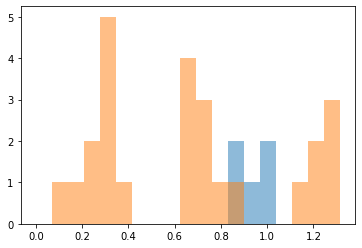

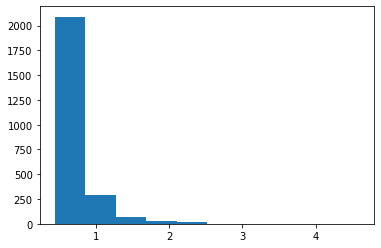

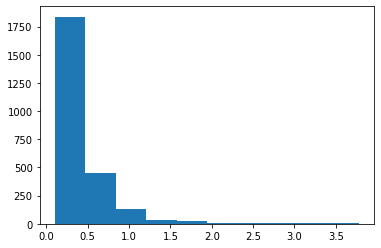

In [96]:
# Sanity check
adata = read_h5ad('/n/home11/mjzhang/gwas_informed_scRNAseq/scDRS/scdrs/data/toydata_mouse.h5ad')
perturb_gene_list = adata.var_names[adata.var['label']]
perturb_cell_list = adata.obs_names[adata.obs['label']]

v_score = np.array(adata[:, perturb_gene_list].X.mean(axis=1)).flatten()
plt.figure()
plt.hist(v_score[adata.obs['label']], alpha=0.5, bins=np.linspace(0,v_score.max(),20))
plt.hist(v_score[~adata.obs['label']], alpha=0.5, bins=np.linspace(0,v_score.max(),20))
plt.show()

# Mean and variance 
plt.figure()
plt.hist(adata.X.toarray().mean(axis=0))
plt.show()

plt.figure()
plt.hist(adata.X.toarray().var(axis=0))
plt.show()

In [104]:
v_raw_score = np.ones(19)

In [106]:
ind_zero_score = (v_raw_score==0)
v_norm_score = (v_raw_score - 0) / 1
v_norm_score[ind_zero_score] = 0-1e-3